<a href="https://colab.research.google.com/github/YasirHabib/Deep-Learning-Advanced-Computer-Vision/blob/master/style_transfer_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [0]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from scipy.optimize import fmin_l_bfgs_b

In [0]:
def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img

In [0]:
def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x

Mounted at /content/gdrive


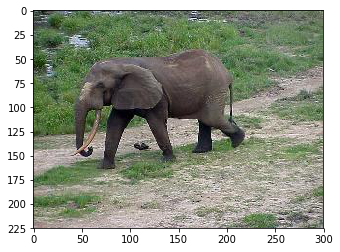

In [46]:
if __name__ == '__main__':
  
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  
  path = '/content/gdrive/My Drive/Colab Notebooks/Deep Learning: Advanced Computer Vision/image_0002.jpg'
  img = image.load_img(path)
  plt.imshow(img)